In [9]:

# bootstrap plot: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.bootstrap_plot.html

import os
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import bootstrap_plot
#import plotly.plotly as py
#import plotly
#import plotly.figure_factory as ff
import datetime
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from matplotlib.dates import DateFormatter
import tikzplotlib
import matplotlib


from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": [
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage{cmbright}",
         ]
})


#plotly.tools.set_config_file(world_readable=True, sharing="public")


path = "./src/Data/Training"

all_files = []
for root,d_names,f_names in os.walk(path):
    for f in f_names:
        all_files.append(os.path.join(root, f))
#print("all files = %s" %all_files)

def getDFForDataSource(data_source):
    file_list_a = []
    for f in all_files:
        if "A-" + data_source + ".csv" in f:
            file_list_a.append(f)
    df_a = pd.concat([pd.read_csv(f,  delimiter=";") for f in file_list_a ], sort=True)
    file_list_b = []
    for f in all_files:
        if "B-" + data_source + ".csv" in f:
            file_list_b.append(f)
    df_b = pd.concat([pd.read_csv(f,  delimiter=";") for f in file_list_b ], sort=True)
    file_list_c = []
    for f in all_files:
        if "C-" + data_source + ".csv" in f:
            file_list_c.append(f)
    df_c = pd.concat([pd.read_csv(f,  delimiter=";") for f in file_list_c ], sort=True)
    df_a["segment"] = "A"
    df_b["segment"] = "B"
    df_c["segment"] = "C"
    return pd.concat([df_a, df_b, df_c], sort=True)


# get data frame for data source from CSV files
activities_df = getDFForDataSource("activity")


activities_df["begin"] = activities_df["DATE BEGIN"]
activities_df["end"] = activities_df["DATE END"]
activities_df.drop(["DATE BEGIN"], axis=1, inplace=True)
activities_df.drop(["DATE END"], axis=1, inplace=True)
activities_df["begin"] = pd.to_datetime(activities_df["begin"])
activities_df["end"] = pd.to_datetime(activities_df["end"])
activities_df["duration"] = activities_df["end"] - activities_df["begin"]
activities = pd.read_csv("./src/activities.csv", delimiter=",")
activities_df = pd.merge(activities_df, activities, on="ACTIVITY")


# GANTT chart

# # filter for segment A (morning)
# is_segment_a =  activities_df["segment"]=="A"
# segment_a_df = activities_df[is_segment_a]
# 
# is_day_2017_10_31 = segment_a_df["begin"].dt.date == datetime.date(2017, 10, 31)
# segment_a_day_2017_10_31 = segment_a_df[is_day_2017_10_31]
# print(segment_a_day_2017_10_31.head())
# 
# 
# segment_a_day_2017_10_31_gantt = segment_a_day_2017_10_31[["begin", "Activity Name", "end"]].copy()
# 
# segment_a_day_2017_10_31_gantt.columns = ["Start", "Task", "Finish"]
# segment_a_day_2017_10_31_gantt.reset_index(inplace=True)
# print(segment_a_day_2017_10_31_gantt)
# 
# 
# 
# fig = ff.create_gantt(segment_a_day_2017_10_31_gantt, title="GANTT Chart of Activities of Morning Segment (31st of October, 2017)")
# fig['layout'].update(autosize=False, width=800, height=500, margin=dict(l=150))
# 
# py.iplot(fig, filename='activities-segment-a-2017-10-31')



  Activity Name  duration
0       Wake up      67.0
1       Wake up     129.0
2       Wake up     167.0
3       Wake up      61.0
4       Wake up     202.0


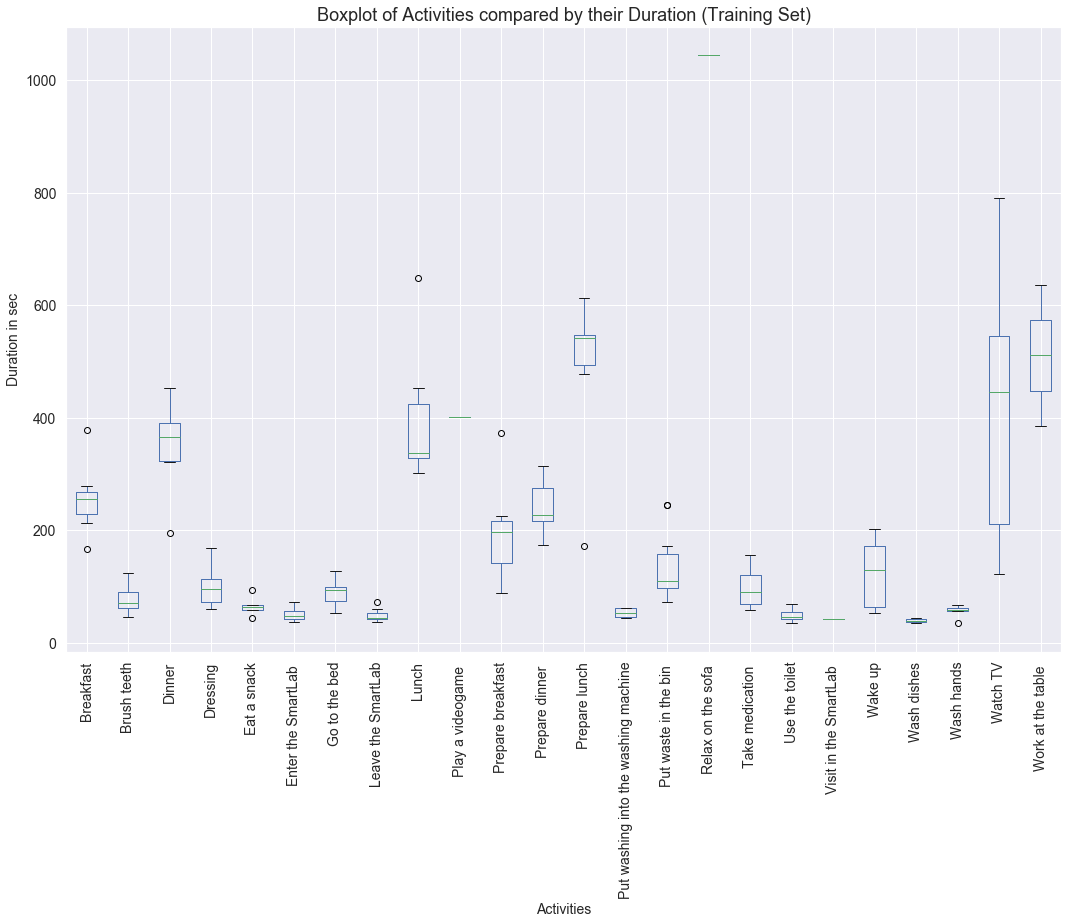

In [10]:
# activity duration boxplott


activities_df_boxplot = activities_df[["Activity Name", "duration"]].copy()
activities_df_boxplot["duration"] = activities_df_boxplot["duration"].dt.total_seconds()


print(activities_df_boxplot.head())


# prepare dataframe for plot
activities_df_boxplot = activities_df_boxplot.set_index("Activity Name", append=True)["duration"].unstack()


# boxplott durations per activity in the morning
ax1 = activities_df_boxplot.plot.box(stacked=True, figsize=(15,13), rot=90)
ax1.set_xlabel("Activities", fontsize =14)
ax1.set_ylabel("Duration in sec", fontsize =14)
ax1.set_title("Boxplot of Activities compared by their Duration (Training Set)", fontsize=18) 
ax1.tick_params(labelsize=14)

plt.tight_layout()
#plt.savefig('./src/figures/durations.png')
plt.savefig('./src/figures/durations.pgf')
tikzplotlib.save("./src/figures/durations-training.tex")


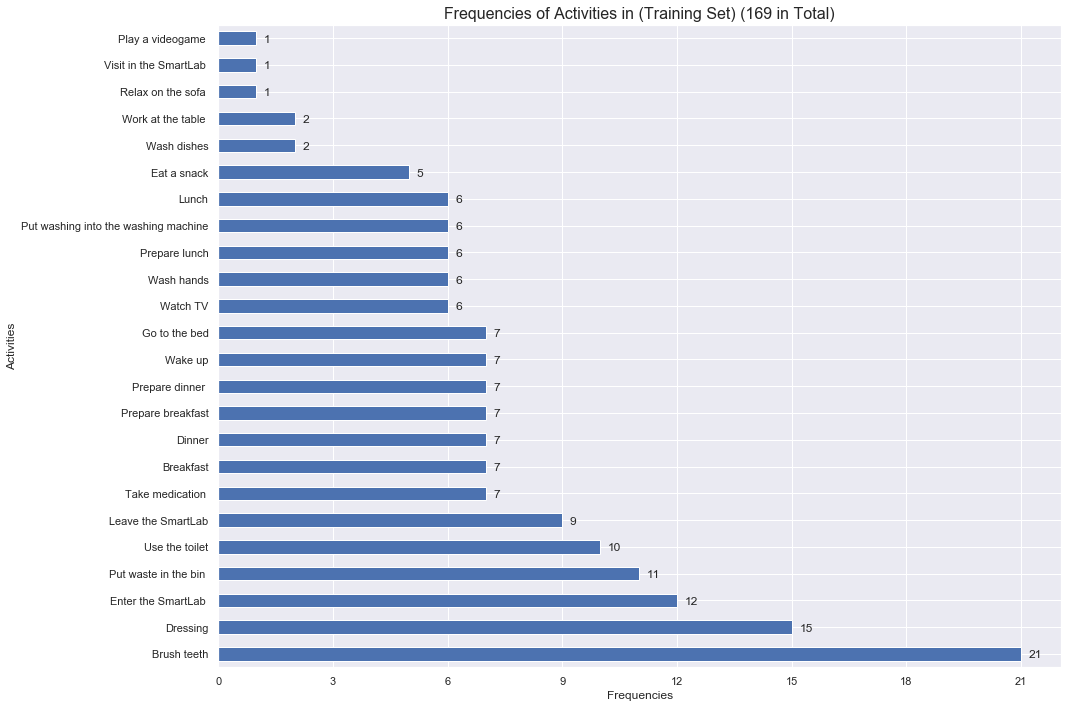

In [11]:
# activities frequencies

activity_occurrences = activities_df["Activity Name"].value_counts()
# get sum of samples
sum_occurrences = activity_occurrences.sum(axis = 0, skipna = True) 

ax = activity_occurrences.plot.barh(figsize=(15,10))
ax.set_title("Frequencies of Activities in (Training Set) (" + str(sum_occurrences) + " in Total)", fontsize=16) 
ax.set_xlabel("Frequencies",fontsize =12)
ax.set_ylabel("Activities", fontsize =12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

x_offset = 0.2
y_offset = -0.4
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.x1 + b.x0)  
    ax.annotate(val, ((b.x0 + b.x1) + x_offset, b.y1 + y_offset))

plt.tight_layout()
#plt.savefig('./src/figures/frequencies.png')
tikzplotlib.save("./src/figures/frequencies-training.tex")


In [12]:
raw_data = pd.read_csv("./src/samples-training.csv",  delimiter=";")
raw_data["TIMESTAMP"] = pd.to_datetime(raw_data["TIMESTAMP"])
pearson_data = raw_data.drop(["TIMESTAMP"], axis=1).drop(["activity"], axis=1)
print(pearson_data.head())
pearson_correlation = pearson_data.corr(method="pearson")


sns.set()
plt.figure(figsize = (50,50))
ax = sns.heatmap(pearson_correlation, annot=True, fmt=".1%")
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('Features', fontweight='bold', fontsize=40)
plt.ylabel('Features', fontweight='bold', fontsize=40)
plt.title("Pearson Correlation Coefficient for Features (Training Set)", fontsize=70)
plt.tight_layout()
plt.savefig('./src/figures/pearson.png')
#plt.savefig('./src/figures/pearson.pgf')
tikzplotlib.save("./src/figures/pearson-training.tex")

   BATHROOM TAP  BED  BOOK  Medication Box Sensor  Fruit Platter Sensor  \
0           0.0  0.0   0.0                    0.0                   0.0   
1           0.0  0.0   0.0                    0.0                   0.0   
2           0.0  0.0   0.0                    0.0                   0.0   
3           0.0  0.0   0.0                    0.0                   0.0   
4           0.0  0.0   0.0                    0.0                   0.0   

   Pots Sensor  Water Bottle Sensor  Trash Sensor  Tap Sensor  Tank Sensor  \
0          0.0                  0.0           0.0         0.0          0.0   
1          0.0                  0.0           0.0         0.0          0.0   
2          0.0                  0.0           0.0         0.0          0.0   
3          0.0                  0.0           0.0         0.0          0.0   
4          0.0                  0.0           0.0         0.0          0.0   

   ...  floor_04,03  floor_04,04  floor_04,05  floor_04,06  floor_04,07  \
0  ..

/home/linda/Uni/Master_Thesis/play/HAR_master_thesis/venv/lib/python3.6/site-packages/tikzplotlib/_axes.py:330: MatplotlibDeprecationWarning: 
The get_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.get_clim instead.
  limits = colorbar.get_clim()
/home/linda/Uni/Master_Thesis/play/HAR_master_thesis/venv/lib/python3.6/site-packages/tikzplotlib/_axes.py:396: MatplotlibDeprecationWarning: 
The get_cmap function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.get_cmap instead.
  mycolormap, is_custom_cmap = _mpl_cmap2pgf_cmap(colorbar.get_cmap(), data)


In [13]:
# from sklearn.decomposition import PCA
# pca = PCA()
# pca.fit(pearson_data)
# X_pca = pca.transform(pearson_data)
# print("original shape:   ", pearson_data.shape)
# print("transformed shape:", X_pca.shape)
# print(pearson_data)
# print(X_pca)


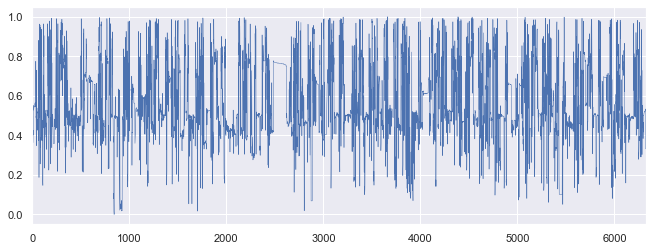

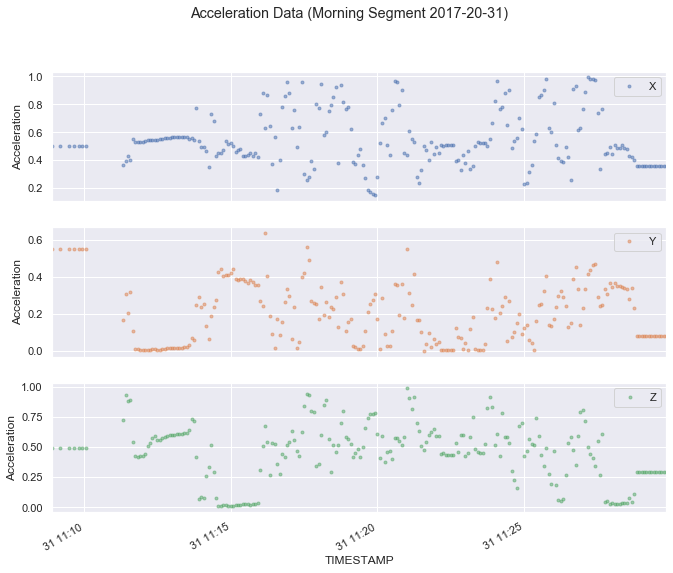

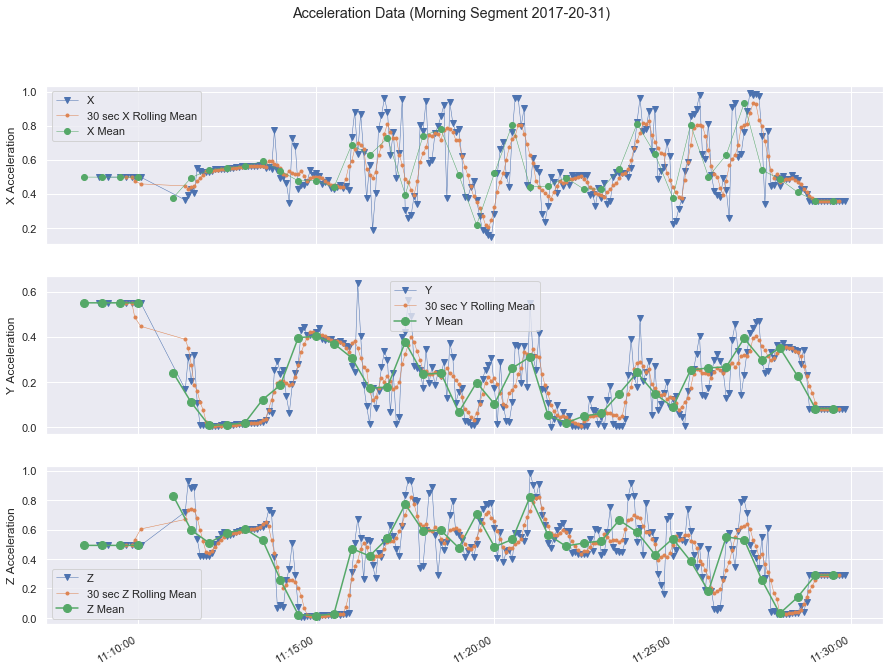

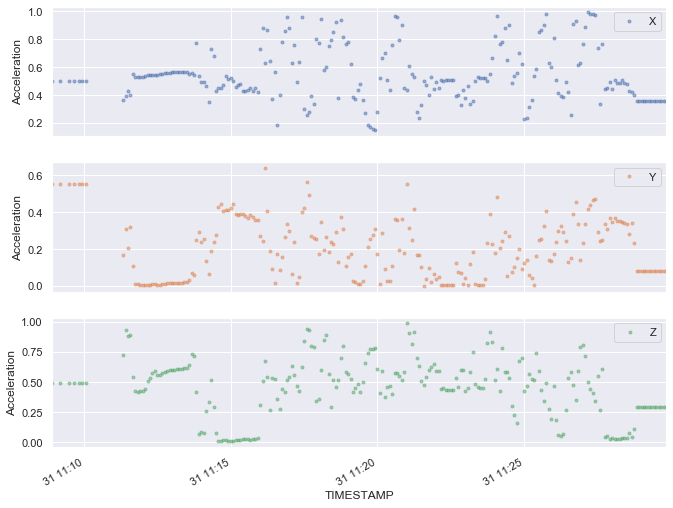

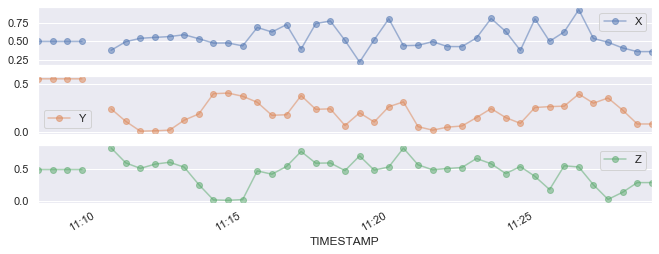

In [14]:
# visualise time series data 
# https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/


sns.set(rc={'figure.figsize':(11, 4)})
raw_data['X'].plot(linewidth=0.5)
tikzplotlib.save("./src/figures/timeseries.tex")


# filter for segment A (morning)
#print(raw_data)
is_segment_a =  raw_data["segment"] == 0
segment_a_df = raw_data[is_segment_a]
is_day_2017_10_31 = segment_a_df["TIMESTAMP"].dt.date == datetime.date(2017, 10, 31)
segment_a_day_2017_10_31 = segment_a_df[is_day_2017_10_31]


segment_a_day_2017_10_31 = segment_a_day_2017_10_31.set_index("TIMESTAMP")

cols_plot = ['X', 'Y', 'Z']
axes = segment_a_day_2017_10_31[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True, title='Acceleration Data (Morning Segment 2017-20-31)')
for ax in axes:
    ax.set_ylabel('Acceleration')
#fig.suptitle('Acceleration Data (Morning Segment 2017-20-31)')  
plt.savefig('./src/figures/time-series.png')
#tikzplotlib.save("./src/figures/time-series.tex", figureheight='\\figH', figurewidth='\\figW')


# Plot mean and X together
mean = segment_a_day_2017_10_31.resample("30s").mean()
rolling_mean = segment_a_day_2017_10_31.rolling(6, center=True).mean()
fig, (ax_x, ax_y, ax_z) = plt.subplots(3)
fig.suptitle('Acceleration Data (Morning Segment 2017-20-31)')
fig.set_figheight(11)
fig.set_figwidth(15)
myFmt = DateFormatter("%H:%M:%S")
fig.autofmt_xdate()

# X
ax_x.plot(segment_a_day_2017_10_31["X"], marker='v', linestyle='-', linewidth=0.5, label='X')
ax_x.plot(rolling_mean["X"], marker='.', linestyle='-', linewidth=0.5, label='30 sec X Rolling Mean')
ax_x.plot(mean["X"], marker='o', linestyle='-', linewidth=0.5, label='X Mean')
ax_x.set_ylabel('X Acceleration')
ax_x.xaxis.set_major_formatter(myFmt)
ax_x.legend()


# Y
ax_y.plot(segment_a_day_2017_10_31["Y"], marker='v', linestyle='-', linewidth=0.5, label='Y')
ax_y.plot(rolling_mean["Y"], marker='.', linestyle='-', linewidth=0.5, label='30 sec Y Rolling Mean')
ax_y.plot(mean["Y"], marker='o', markersize=8, linestyle='-', label='Y Mean')
ax_y.set_ylabel('Y Acceleration')
ax_y.xaxis.set_major_formatter(myFmt)
ax_y.legend()

# Z
ax_z.plot(segment_a_day_2017_10_31["Z"], marker='v', linestyle='-', linewidth=0.5, label='Z')
ax_z.plot(rolling_mean["Z"], marker='.', linestyle='-', linewidth=0.5, label='30 sec Z Rolling Mean')
ax_z.plot(mean["Z"], marker='o', markersize=8, linestyle='-', label='Z Mean')
ax_z.set_ylabel('Z Acceleration')
ax_z.xaxis.set_major_formatter(myFmt)
ax_z.legend()




#plt.savefig('./src/figures/acceleration.png')
plt.savefig('./src/figures/acceleration.pgf')
#tikzplotlib.save('./src/figures/acceleration.tex')


cols_plot = ['X', 'Y', 'Z']
axes = segment_a_day_2017_10_31[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
axes2 = mean[cols_plot].plot(marker='o', alpha=0.5, linestyle='-', subplots=True)
for ax in axes:
    ax.set_ylabel('Acceleration')



NameError: name 'plt' is not defined

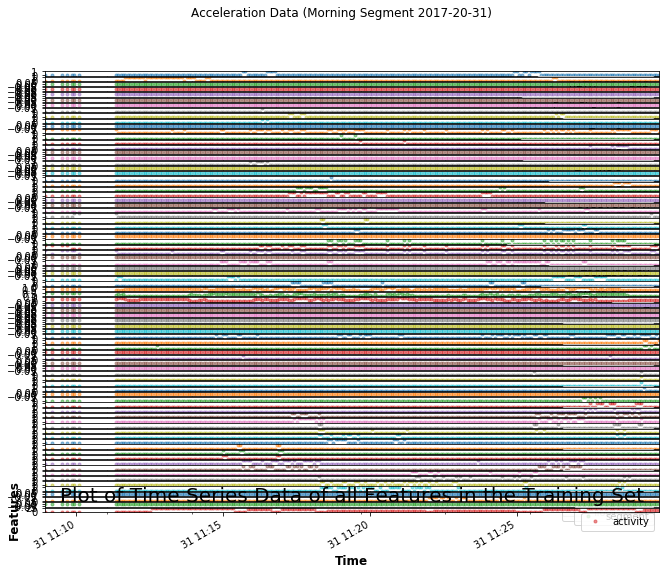

In [13]:
from pandas import DataFrame
from pandas import Grouper
import pandas as pd
import datetime
from matplotlib import pyplot
training_samples_to_analyse = pd.read_csv("./src/samples-training.csv",  delimiter=";")#, header=0, index_col=0, parse_dates=True, squeeze=True)

training_samples_to_analyse.drop(["activity"], axis=1)

training_samples_to_analyse['TIMESTAMP'] = pd.to_datetime(training_samples_to_analyse['TIMESTAMP'])
#training_samples_to_analyse = training_samples_to_analyse.set_index('TIMESTAMP')




is_segment_a =  training_samples_to_analyse["segment"] == 0
segment_a_df = training_samples_to_analyse[is_segment_a]
is_day_2017_10_31 = segment_a_df["TIMESTAMP"].dt.date == datetime.date(2017, 10, 31)
segment_a_day_2017_10_31 = segment_a_df[is_day_2017_10_31]
# 
# 
segment_a_day_2017_10_31 = segment_a_day_2017_10_31.set_index("TIMESTAMP")
    
#segment_a_day_2017_10_31.head(50).plot(subplots=True, legend=False)

#cols_plot = [training_samples_to_analyse.columns.values]
axes = segment_a_day_2017_10_31.plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True, title='Acceleration Data (Morning Segment 2017-20-31)')
#for ax in axes:
    #ax.set_ylabel('test')


#segment_a_day_2017_10_31.head(10).plot(marker='.', alpha=0.5, linestyle='None', subplots=True, legend=False)
pyplot.suptitle("Plot of Time Series Data of all Features in the Training Set", fontsize=20)
pyplot.xlabel('Time', fontweight='bold', fontsize=12)
pyplot.ylabel('Features', fontweight='bold', fontsize=12)



pyplot.savefig('./src/figures/time-series-features.pgf')
pyplot.savefig('./src/figures/time-series-features.png')
pyplot.show()

   BATHROOM TAP  BED  BOOK  Medication Box Sensor  Fruit Platter Sensor  \
0           0.0  0.0   0.0                    0.0                   0.0   
1           0.0  0.0   0.0                    0.0                   0.0   
2           0.0  0.0   0.0                    0.0                   0.0   
3           0.0  0.0   0.0                    0.0                   0.0   
4           0.0  0.0   0.0                    0.0                   0.0   

   Pots Sensor  Water Bottle Sensor  Trash Sensor  Tap Sensor  Tank Sensor  \
0          0.0                  0.0           0.0         0.0          0.0   
1          0.0                  0.0           0.0         0.0          0.0   
2          0.0                  0.0           0.0         0.0          0.0   
3          0.0                  0.0           0.0         0.0          0.0   
4          0.0                  0.0           0.0         0.0          0.0   

   ...  floor_04,03  floor_04,04  floor_04,05  floor_04,06  floor_04,07  \
0  ..

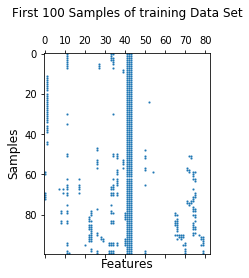

In [25]:
training_samples_to_analyse = pd.read_csv("./src/samples-training.csv",  delimiter=";")#, header=0, index_col=0, parse_dates=True, squeeze=True)

training_samples_to_analyse = training_samples_to_analyse.drop(["activity"], axis=1)
training_samples_to_analyse = training_samples_to_analyse.drop(["TIMESTAMP"], axis=1)

print(training_samples_to_analyse.head())



pyplot.spy(training_samples_to_analyse.head(100), markersize=1)
pyplot.title('First 100 Samples of training Data Set')
pyplot.ylabel('Samples', fontsize=12)
pyplot.xlabel('Features', fontsize=12)

ax = pyplot.gca()
ttl = ax.title
ttl.set_position([.5, 1.15])
pyplot.tight_layout()

pyplot.savefig('./src/figures/sparse.pgf')
pyplot.savefig('./src/figures/sparse.png')